# Phase 1 Project

In [1]:

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from helper import *
import optuna
from optuna.samplers import NSGAIISampler, TPESampler, RandomSampler
from functools import partial
from Strategy import Strategy_1, Strategy_2
import numpy as np
import pandas as pd
import os
import sys
import json

seed = 42

c:\Users\admin\OneDrive\Desktop\Final\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prepare Data

In [2]:
# # get the matched data from database
# get_matched("2020-01-01 00:00:00", "2024-01-01 00:00:00", "Data\\IS_matched.csv")
# get_matched("2024-01-01 00:00:00", "2024-12-28 00:00:00", "Data\\OS_matched.csv")

### In-Out Matched data

In [3]:
IS_matched = pd.read_csv("Data\\IS_matched.csv")
IS_matched["datetime"] = pd.to_datetime(IS_matched["datetime"])
IS_matched.set_index("datetime", inplace=True)
IS_matched

,tickersymbol,price,volume
datetime,,,
2021-06-01 09:00:33.039040,VN30F2106,1483.8,1
2021-06-01 09:02:15.648543,VN30F2106,1483.0,12
2021-06-01 09:02:52.934966,VN30F2106,1483.1,1
2021-06-01 09:03:03.053928,VN30F2106,1483.3,2
2021-06-01 09:03:16.734265,VN30F2106,1483.6,2
...,...,...,...
2023-12-29 14:29:42.925354,VN30F2401,1133.9,3
2023-12-29 14:29:49.245687,VN30F2401,1134.4,5
2023-12-29 14:29:52.292383,VN30F2401,1133.9,1


In [4]:
OS_matched = pd.read_csv("Data\\OS_matched.csv")
OS_matched["datetime"] = pd.to_datetime(OS_matched["datetime"])
OS_matched.set_index("datetime", inplace=True)
OS_matched

,tickersymbol,price,volume
datetime,,,
2024-01-02 09:00:43.630926,VN30F2401,1138.6,7
2024-01-02 09:00:50.832268,VN30F2401,1138.5,1
2024-01-02 09:00:56.494690,VN30F2401,1138.7,2
2024-01-02 09:01:01.565763,VN30F2401,1138.5,1
2024-01-02 09:01:07.677574,VN30F2401,1138.8,2
...,...,...,...
2024-12-27 14:29:47.281494,VN30F2501,1355.9,7
2024-12-27 14:29:50.343408,VN30F2501,1355.8,1
2024-12-27 14:29:52.367822,VN30F2501,1355.7,8


### Group Data into OHLC

In [5]:
# group_to_ohlc(IS_matched, freq="1D").to_csv("Data\\IS_matched_1D.csv")
# group_to_ohlc(IS_matched, freq="1h").to_csv("Data\\IS_matched_1H.csv")
# group_to_ohlc(IS_matched, freq="5min").to_csv("Data\\IS_matched_5min.csv")
# group_to_ohlc(IS_matched, freq="1min").to_csv("Data\\IS_matched_1min.csv")

sample = pd.read_csv("Data\\IS_matched_1min.csv")
sample

,datetime,Open,High,Low,Close,Volume,VWAP
0,2021-06-01 09:00:00,1483.8,1483.8,1483.8,1483.8,1.0,1483.800000
1,2021-06-01 09:02:00,1483.0,1483.1,1483.0,1483.1,13.0,1483.007692
2,2021-06-01 09:03:00,1483.3,1483.7,1483.1,1483.3,38.0,1483.371053
3,2021-06-01 09:04:00,1483.7,1484.0,1483.1,1483.1,30.0,1483.590000
4,2021-06-01 09:05:00,1483.4,1483.4,1482.4,1482.6,35.0,1482.602857
...,...,...,...,...,...,...,...
155142,2023-12-29 14:25:00,1133.5,1133.9,1133.3,1133.9,19.0,1133.542105
155143,2023-12-29 14:26:00,1133.8,1133.8,1132.2,1133.4,37.0,1133.164865
155144,2023-12-29 14:27:00,1133.3,1133.5,1133.0,1133.5,36.0,1133.283333
155145,2023-12-29 14:28:00,1134.2,1134.9,1133.8,1133.9,66.0,1134.039394


In [6]:
# group_to_ohlc(OS_matched, freq="1D").to_csv("Data\\OS_matched_1D.csv")
# group_to_ohlc(OS_matched, freq="1h").to_csv("Data\\OS_matched_1H.csv")
# group_to_ohlc(OS_matched, freq="5min").to_csv("Data\\OS_matched_5min.csv")
# group_to_ohlc(OS_matched, freq="1min").to_csv("Data\\OS_matched_1min.csv")

sample = pd.read_csv("Data\\OS_matched_1min.csv")
sample

,datetime,Open,High,Low,Close,Volume,VWAP
0,2024-01-02 09:00:00,1138.6,1138.7,1138.5,1138.7,10.0,1138.610000
1,2024-01-02 09:01:00,1138.5,1139.6,1138.5,1139.3,90.0,1139.221111
2,2024-01-02 09:02:00,1139.3,1139.5,1139.2,1139.3,76.0,1139.426316
3,2024-01-02 09:03:00,1139.2,1139.3,1138.9,1138.9,45.0,1139.186667
4,2024-01-02 09:04:00,1139.0,1139.0,1138.8,1138.8,22.0,1138.886364
...,...,...,...,...,...,...,...
59554,2024-12-27 14:25:00,1356.6,1356.8,1356.4,1356.6,39.0,1356.520513
59555,2024-12-27 14:26:00,1356.5,1356.5,1355.6,1355.9,54.0,1355.909259
59556,2024-12-27 14:27:00,1355.7,1356.4,1355.7,1356.1,34.0,1355.994118
59557,2024-12-27 14:28:00,1356.2,1356.3,1356.0,1356.0,19.0,1356.131579


## Strategy 1: ...

### In-Sample

#### Prepare

In [7]:

def Objective(trial, data, space):
    cut_loss_thres = trial.suggest_float(
        "cut_loss_thres", space["cut_loss_thres"][0], space["cut_loss_thres"][1]
    )
    bb_window = trial.suggest_int(
        "bb_window", space["bb_window"][0], space["bb_window"][1]
    )
    bb_std = trial.suggest_float("bb_std", space["bb_std"][0], space["bb_std"][1])
    sma_window = trial.suggest_int("sma_window", space["sma_window"][0], bb_window)
    
    strategy = Strategy_1(
        name="Strategy_1",
        cut_loss_thres=cut_loss_thres,
        sma_window=sma_window,
        bb_window=bb_window,
        bb_std=bb_std,
    )

    assets = strategy.run(data)
    MDD = strategy.get_MDD()
    risk_free_rate = 0.05 / 252
    sharpe_ratio = calcualte_sharpe_ratio(assets)
    profit = assets["balance"].iloc[-1] / 1000000

    return sharpe_ratio, MDD

In [8]:
IS_matched_1D = pd.read_csv("Data\\IS_matched_1D.csv")
IS_matched_1D["datetime"] = pd.to_datetime(IS_matched_1D["datetime"])
IS_matched_5min = pd.read_csv("Data\\IS_matched_5min.csv")
IS_matched_5min["datetime"] = pd.to_datetime(IS_matched_5min["datetime"])
IS_matched_1min = pd.read_csv("Data\\IS_matched_1min.csv")
IS_matched_1min["datetime"] = pd.to_datetime(IS_matched_1min["datetime"])

#### 1 Day

In [9]:
# study_1D = optuna.create_study(
#     directions=["maximize", "minimize"],
#     sampler=NSGAIISampler(seed=seed),
# )
# space = {
#     "cut_loss_thres": [0.005, 0.02],
#     "sma_window": [3],
#     "bb_window": [5, 50],
#     "bb_std": [1, 3],
# }
# study_1D.optimize(
#     partial(Objective, data=IS_matched_1D, space=space),
#     n_trials=200,
# )

# # To get the best trials in a multi-objective study
# best_trials = [trial for trial in study_1D.best_trials if trial.values[0] > 1]
# save_best_parameters(best_trials, "ST1_best_params_1D.json")

Best Sharpe Ratio: 1.2995812602646715 - Best MDD: 0.2261815509932527
Profit: 5.477780000000009
Best parameters: {'cut_loss_thres': 0.012029909629911894, 'bb_window': 35, 'bb_std': 1.1126065513636747, 'sma_window': 6}


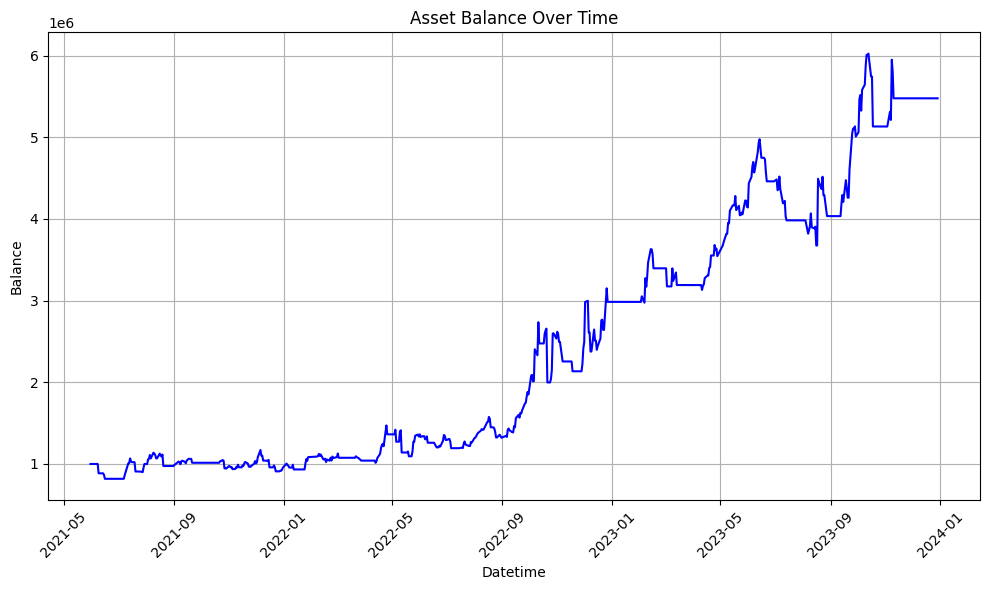

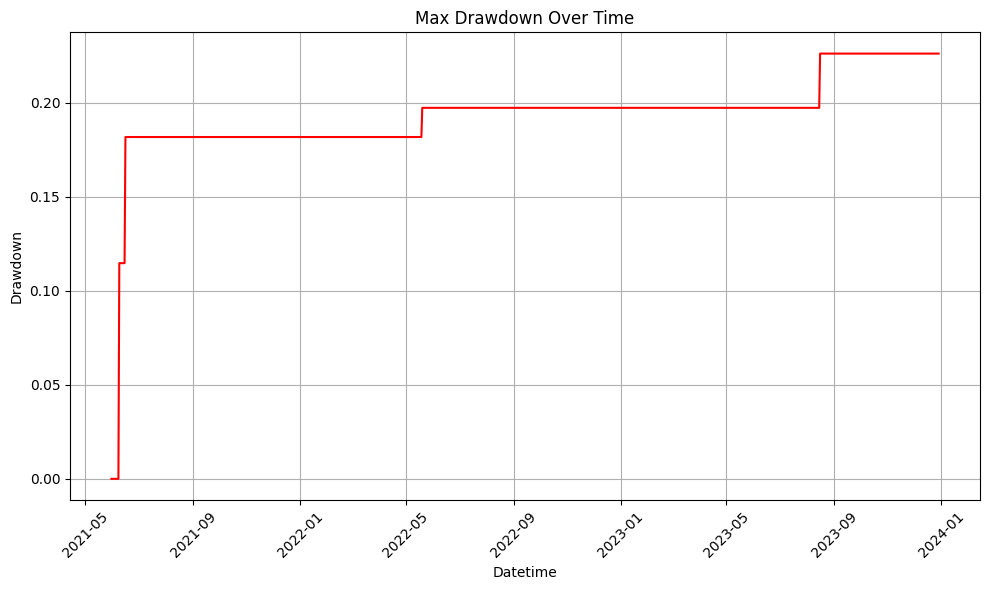

In [10]:
run_strategy_and_plot(Strategy_1, "ST1_best_params_1D.json", IS_matched_1D, "ST1_1D")

#### 5 Minutes

In [11]:
# study_5min = optuna.create_study(
#     directions=["maximize", "minimize"],
#     sampler=NSGAIISampler(seed=seed),
# )
# space = {
#     "cut_loss_thres": [0.0075, 0.02],
#     "sma_window": [3],
#     "bb_window": [5, 150],
#     "bb_std": [1, 3],
# }

# study_5min.optimize(
#     partial(Objective, data=IS_matched_5min, space=space),
#     n_trials=200,
# )

# # To get the best trials in a multi-objective study
# best_trials = [trial for trial in study_5min.best_trials if trial.values[0] > 1]
# save_best_parameters(best_trials, "ST1_best_params_5min.json")

Best Sharpe Ratio: 2.645084747062954 - Best MDD: 0.3661892792717857
Profit: 101.76536500000044
Best parameters: {'cut_loss_thres': 0.009450233005530457, 'bb_window': 27, 'bb_std': 1.116167224336399, 'sma_window': 24}


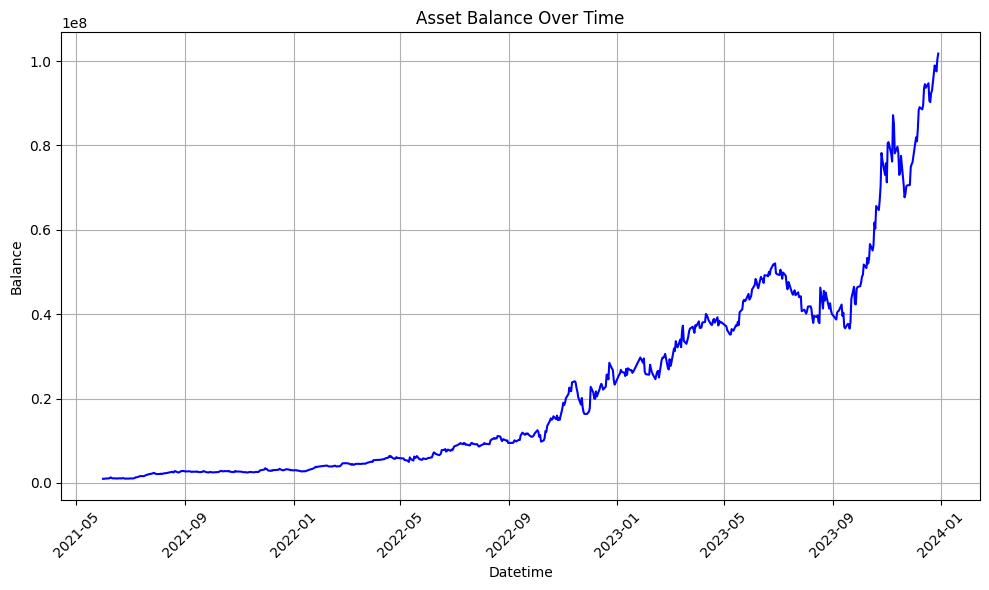

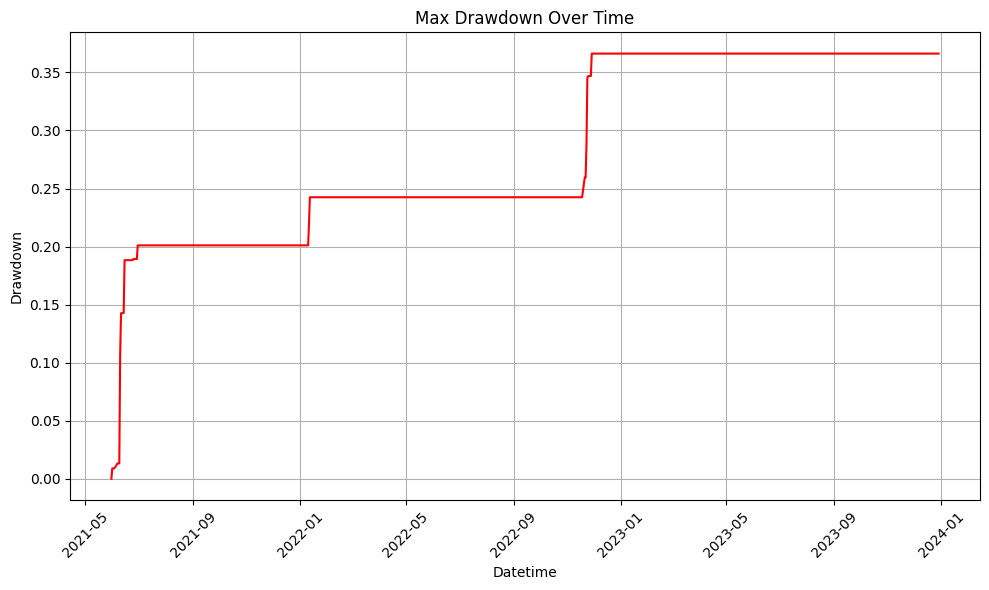

In [12]:
run_strategy_and_plot(
    Strategy_1, "ST1_best_params_5min.json", IS_matched_5min, "ST1_5min"
)

#### 1 Minute

In [13]:
# study_1min = optuna.create_study(
#     directions=["maximize", "minimize"],
#     sampler=NSGAIISampler(seed=seed),
# )
# space = {
#     "cut_loss_thres": [0.0075, 0.02],
#     "sma_window": [3],
#     "bb_window": [5, 150],
#     "bb_std": [1, 3],
# }
# study_1min.optimize(
#     partial(Objective, data=IS_matched_1min, space=space),
#     n_trials=200,
# )

# # To get the best trials in a multi-objective study
# best_trials = [trial for trial in study_1min.best_trials if trial.values[0] > 1]
# save_best_parameters(best_trials, "ST1_best_params_1min.json")

Best Sharpe Ratio: 2.4059867450031067 - Best MDD: 0.23674972221051904
Profit: 39.68626800000001
Best parameters: {'cut_loss_thres': 0.007569026464045029, 'bb_window': 124, 'bb_std': 2.4137146876952342, 'sma_window': 91}


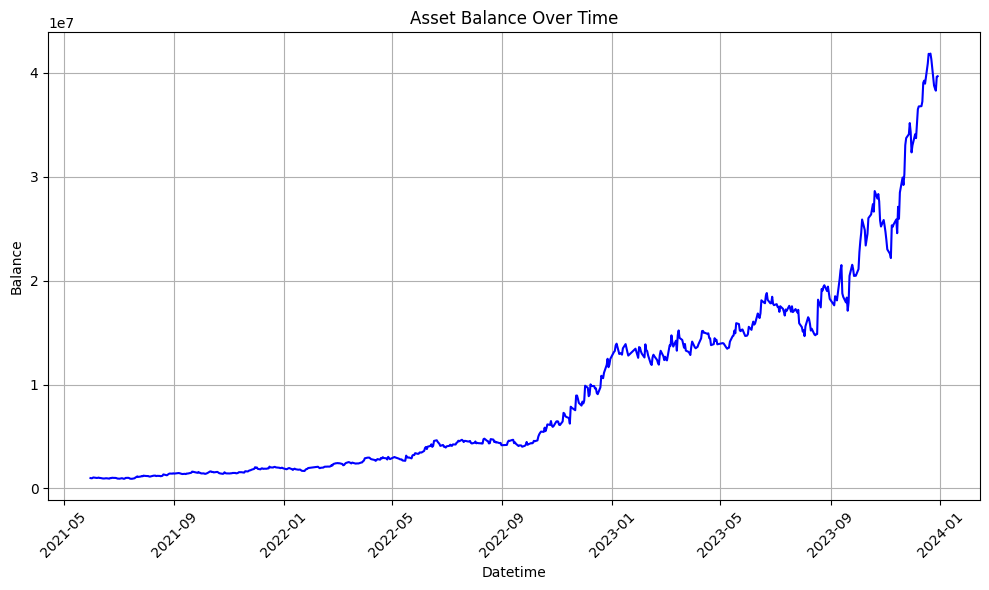

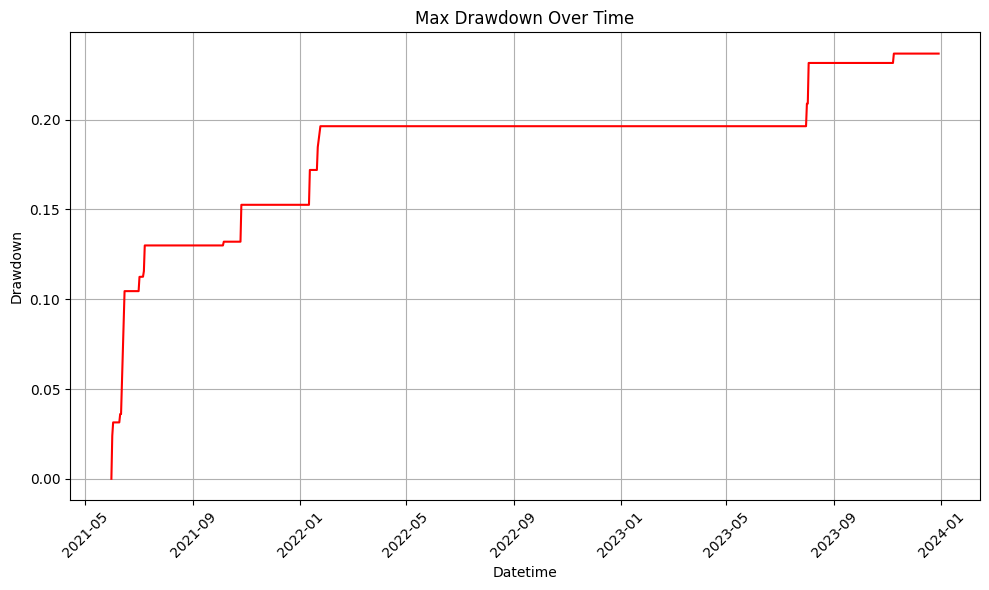

In [14]:
run_strategy_and_plot(
    Strategy_1, "ST1_best_params_1min.json", IS_matched_1min, "ST1_1min"
)

### Out-Sample

In [15]:
OS_matched_1D = pd.read_csv("Data\\OS_matched_1D.csv")
OS_matched_1D["datetime"] = pd.to_datetime(OS_matched_1D["datetime"])
OS_matched_5min = pd.read_csv("Data\\OS_matched_5min.csv")
OS_matched_5min["datetime"] = pd.to_datetime(OS_matched_5min["datetime"])
OS_matched_1min = pd.read_csv("Data\\OS_matched_1min.csv")
OS_matched_1min["datetime"] = pd.to_datetime(OS_matched_1min["datetime"])

#### 1 Day

Best Sharpe Ratio: 0.5586169076134491 - Best MDD: 0.2670430000000005
Profit: 1.2124184999999996
Best parameters: {'cut_loss_thres': 0.012029909629911894, 'bb_window': 35, 'bb_std': 1.1126065513636747, 'sma_window': 6}


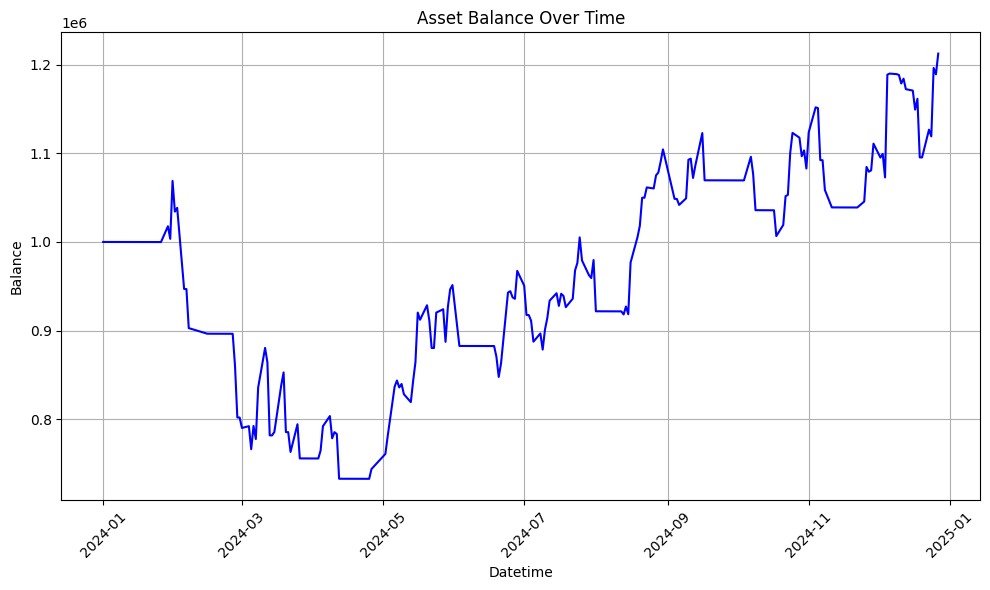

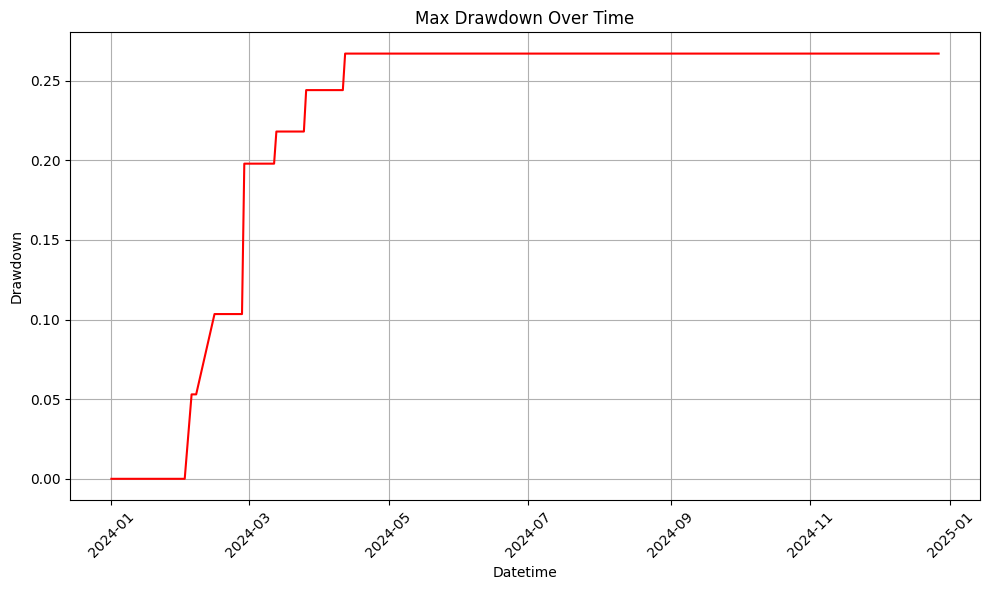

In [16]:
run_strategy_and_plot(
    Strategy_1, "ST1_best_params_1D.json", OS_matched_1D, "ST1_1D"
)

#### 5 Minutes

Best Sharpe Ratio: 2.2060595785234454 - Best MDD: 0.2423004695146447
Profit: 2.9617269999999873
Best parameters: {'cut_loss_thres': 0.009450233005530457, 'bb_window': 27, 'bb_std': 1.116167224336399, 'sma_window': 24}


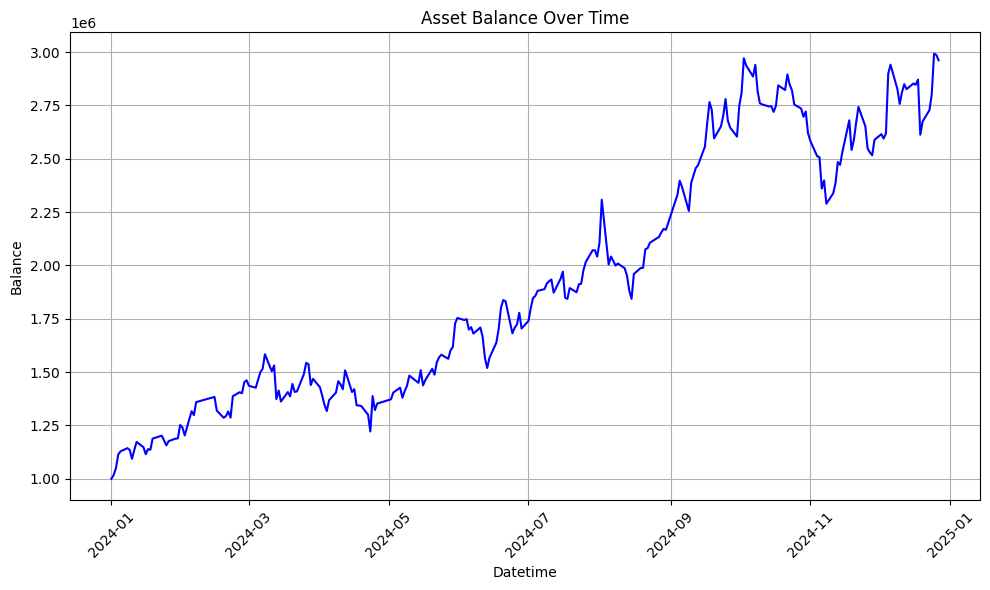

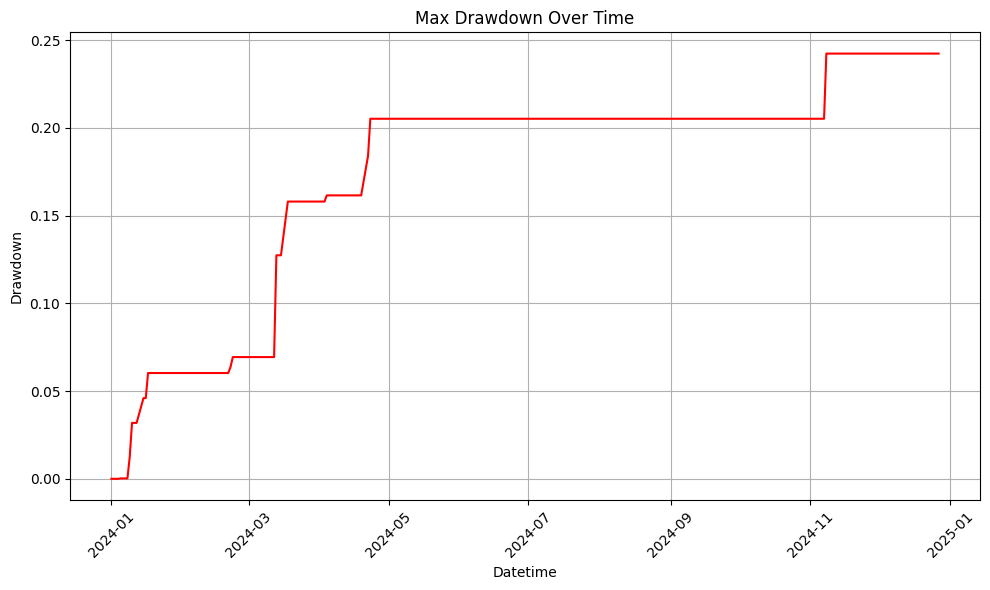

In [17]:
run_strategy_and_plot(
    Strategy_1, "ST1_best_params_5min.json", OS_matched_5min, "ST1_5min"
)

#### 1 Minute

Best Sharpe Ratio: 1.6110704238051705 - Best MDD: 0.3397898712780998
Profit: 2.107345499999984
Best parameters: {'cut_loss_thres': 0.007569026464045029, 'bb_window': 124, 'bb_std': 2.4137146876952342, 'sma_window': 91}


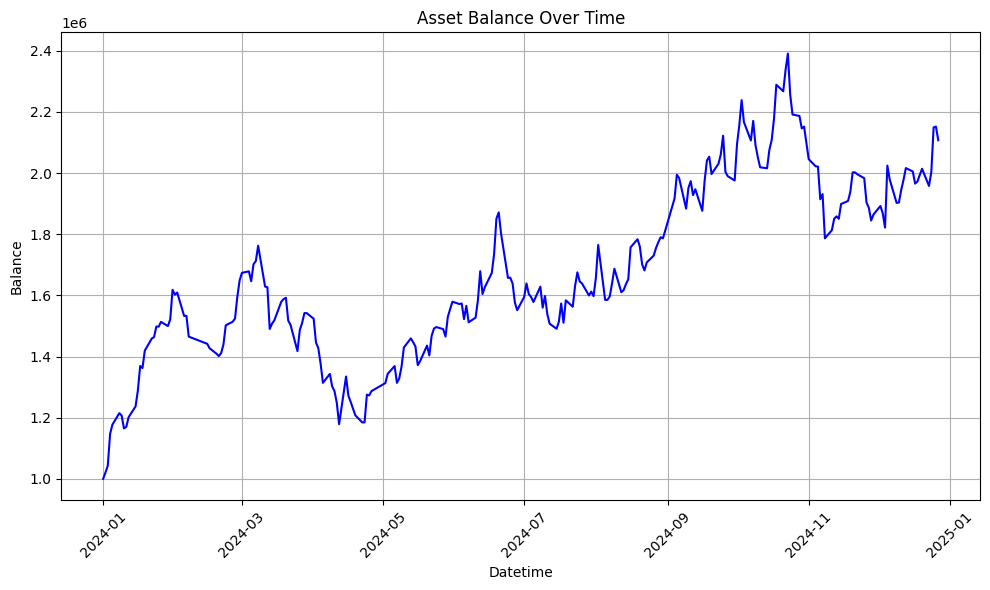

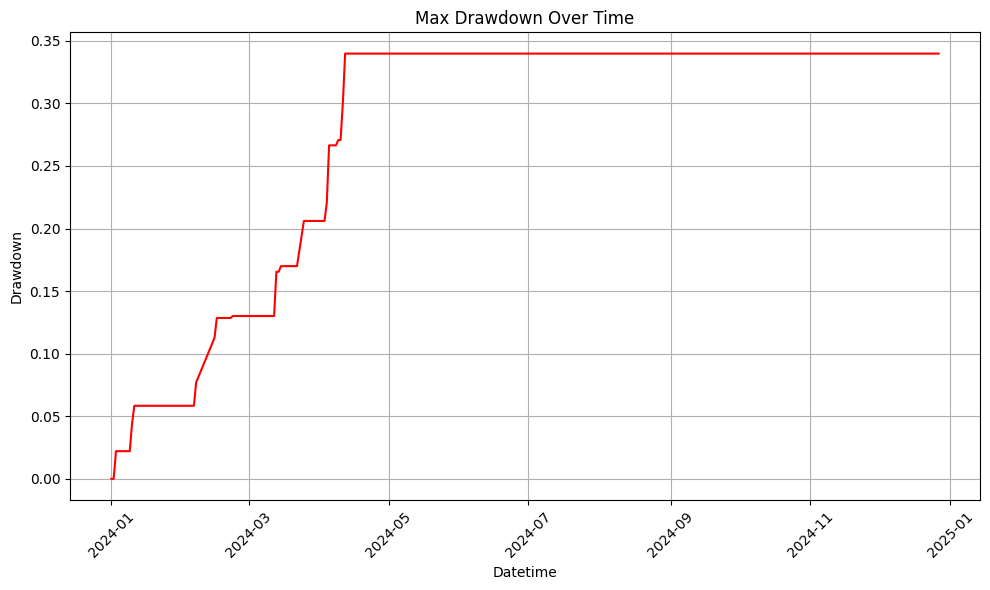

In [18]:
run_strategy_and_plot(
    Strategy_1, "ST1_best_params_1min.json", OS_matched_1min, "ST1_1min"
)

## Strategy 2: ...

### In-Sample

#### Prepare

In [19]:
def Objective_2(trial, data, space):
    cut_loss_thres = trial.suggest_float(
        "cut_loss_thres", space["cut_loss_thres"][0], space["cut_loss_thres"][1]
    )
    lookback_period = trial.suggest_int(
        "lookback_period", space["lookback_period"][0], space["lookback_period"][1]
    )
    upbound = trial.suggest_float("upbound", space["upbound"][0], space["upbound"][1])
    downbound = trial.suggest_float(
        "downbound", space["downbound"][0], space["downbound"][1]
    )
    sma_window = trial.suggest_int(
        "sma_window", space["sma_window"][0], lookback_period
    )

    strategy = Strategy_2(
        name="Strategy_2",
        cut_loss_thres=cut_loss_thres,
        sma_window=sma_window,
        upbound=upbound,
        downbound=downbound,
        lookback_period=lookback_period,
    )

    assets = strategy.run(data)
    MDD = strategy.get_MDD()
    sharpe_ratio = calcualte_sharpe_ratio(assets)
    profit = assets["balance"].iloc[-1] / 1000000

    return sharpe_ratio, MDD

In [20]:
IS_matched_1D = pd.read_csv("Data\\IS_matched_1D.csv")
IS_matched_1D["datetime"] = pd.to_datetime(IS_matched_1D["datetime"])
IS_matched_5min = pd.read_csv("Data\\IS_matched_5min.csv")
IS_matched_5min["datetime"] = pd.to_datetime(IS_matched_5min["datetime"])
IS_matched_1min = pd.read_csv("Data\\IS_matched_1min.csv")
IS_matched_1min["datetime"] = pd.to_datetime(IS_matched_1min["datetime"])

#### 1 Day

In [21]:
# study_1D = optuna.create_study(
#     directions=["maximize", "minimize"],
#     sampler=NSGAIISampler(seed=seed),
# )
# space = {
#     "cut_loss_thres": [0.005, 0.02],
#     "lookback_period": [10, 50],
#     "upbound": [0, 0.1],
#     "downbound": [-0.1, 0],
#     "sma_window": [3],
# }
# study_1D.optimize(
#     partial(Objective_2, data=IS_matched_1D, space=space),
#     n_trials=200,
# )

# # To get the best trials in a multi-objective study
# best_trials = [trial for trial in study_1D.best_trials if trial.values[0] > 1]
# save_best_parameters(best_trials, "ST2_best_params_1D.json")

Best Sharpe Ratio: 1.0622245814431317 - Best MDD: 0.44908028841666053
Profit: 3.9537884999999986
Best parameters: {'cut_loss_thres': 0.009199008454189143, 'lookback_period': 14, 'upbound': 0.009367476782809248, 'downbound': -0.0914652535006232, 'sma_window': 4}


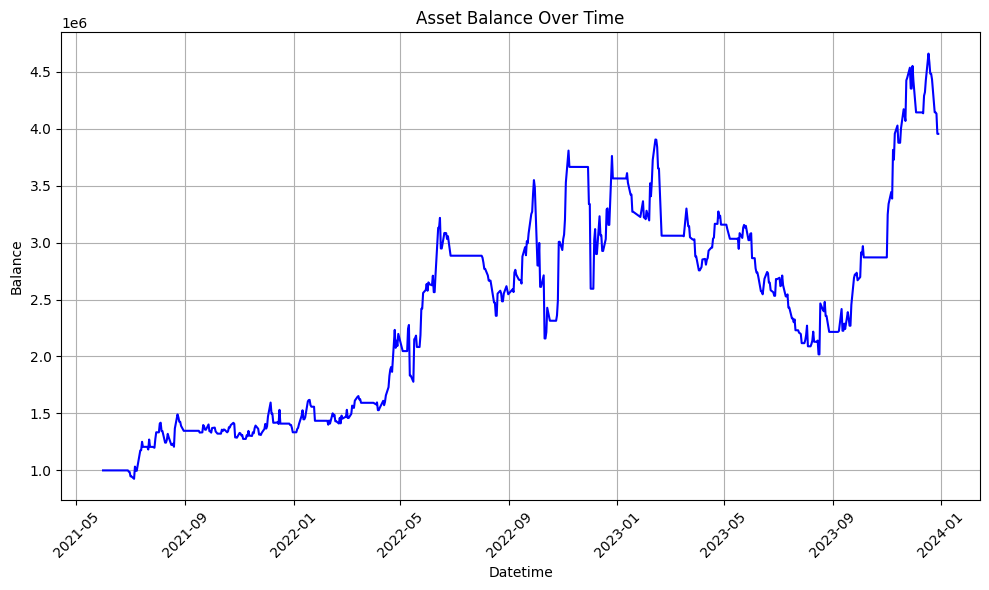

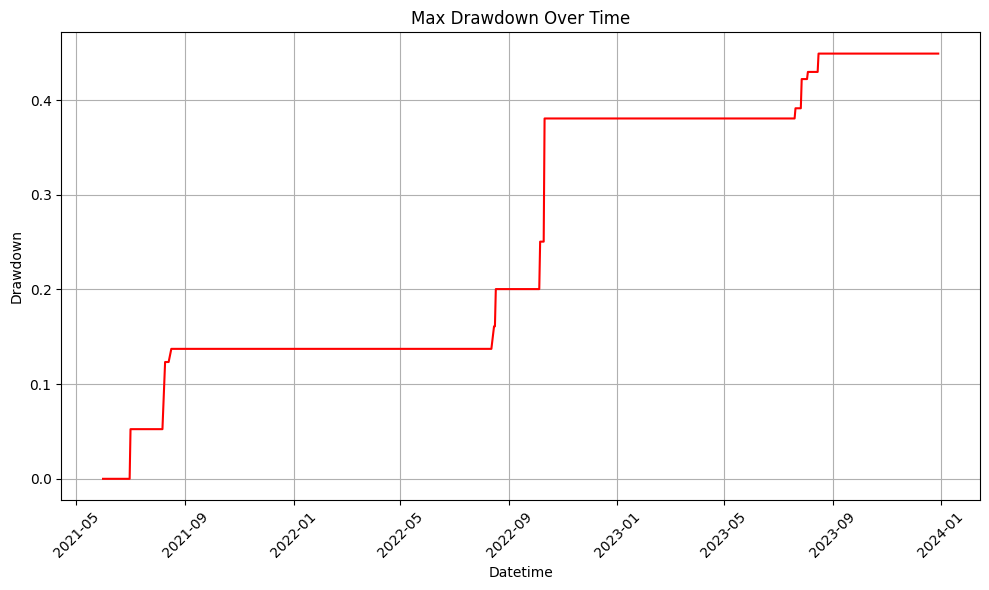

In [22]:
run_strategy_and_plot(Strategy_2, "ST2_best_params_1D.json", IS_matched_1D, "ST2_1D")

#### 5 Minutes

In [23]:
# study_5min = optuna.create_study(
#     directions=["maximize", "minimize"],
#     sampler=NSGAIISampler(seed=seed),
# )
# space = {
#     "cut_loss_thres": [0.005, 0.05],
#     "lookback_period": [10, 500],
#     "upbound": [0, 0.2],
#     "downbound": [-0.2, 0],
#     "sma_window": [3],
# }
# study_5min.optimize(
#     partial(Objective_2, data=IS_matched_5min, space=space),
#     n_trials=200,
# )

# # To get the best trials in a multi-objective study
# best_trials = [trial for trial in study_5min.best_trials if trial.values[0] > 1]
# save_best_parameters(best_trials, "ST2_best_params_5min.json")

Best Sharpe Ratio: 1.174142374961004 - Best MDD: 0.3705798256034764
Profit: 4.916924999999998
Best parameters: {'cut_loss_thres': 0.041334806982382816, 'lookback_period': 282, 'upbound': 0.06360069499437278, 'downbound': -0.07765585075312956, 'sma_window': 120}


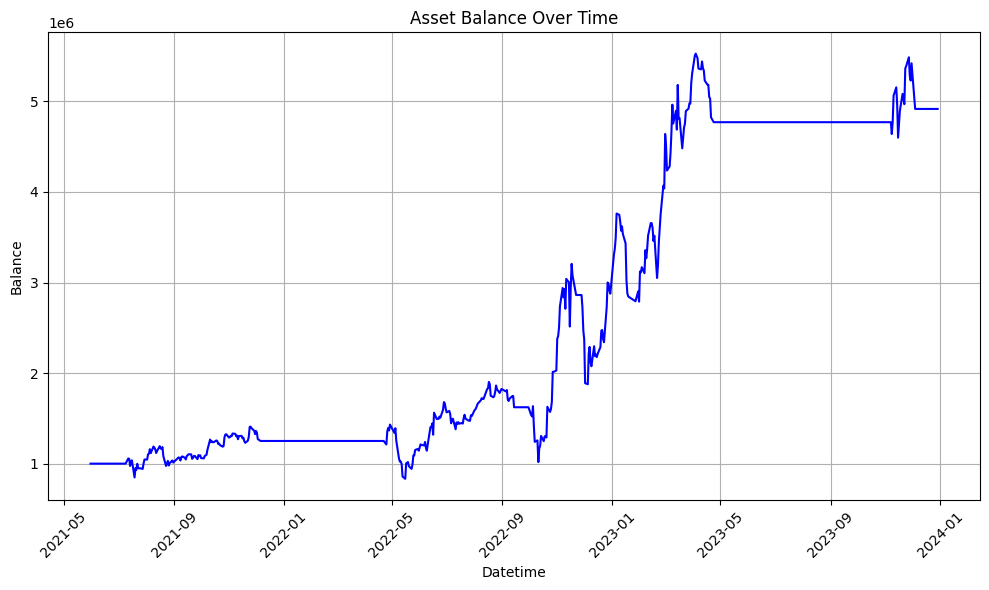

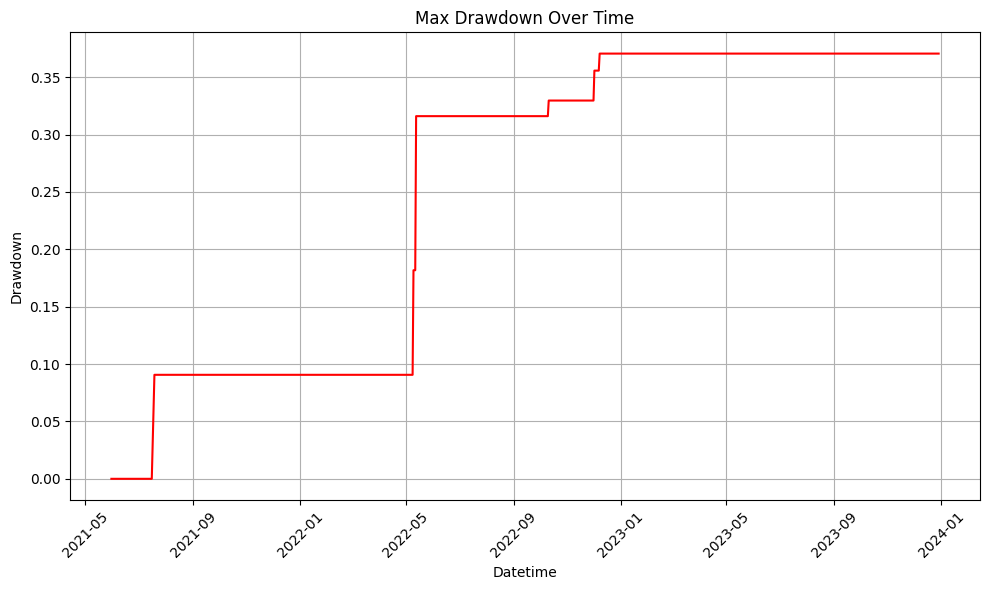

In [24]:
run_strategy_and_plot(
    Strategy_2, "ST2_best_params_5min.json", IS_matched_5min, "ST2_5min"
)

#### 1 Minutes

In [25]:
# study_1min = optuna.create_study(
#     directions=["maximize", "minimize"],
#     sampler=NSGAIISampler(seed=seed),
# )
# space = {
#     "cut_loss_thres": [0.005, 0.02],
#     "lookback_period": [10, 500],
#     "upbound": [0, 0.1],
#     "downbound": [-0.1, 0],
#     "sma_window": [3],
# }
# study_1min.optimize(
#     partial(Objective_2, data=IS_matched_1min, space=space),
#     n_trials=200,
# )

# # To get the best trials in a multi-objective study
# best_trials = [trial for trial in study_1min.best_trials if trial.values[0] > 1]
# save_best_parameters(best_trials, "ST2_best_params_1min.json")

Best Sharpe Ratio: 1.001289023296165 - Best MDD: 0.6860384968199842
Profit: 4.1258154999999865
Best parameters: {'cut_loss_thres': 0.012670135982914067, 'lookback_period': 289, 'upbound': 0.009367476782809248, 'downbound': -0.06322841969405665, 'sma_window': 97}


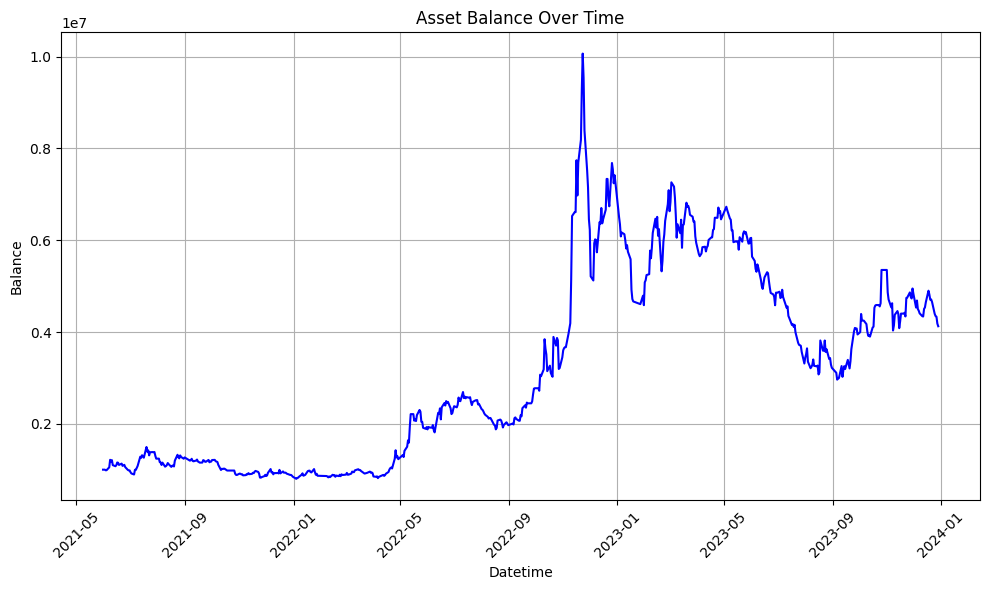

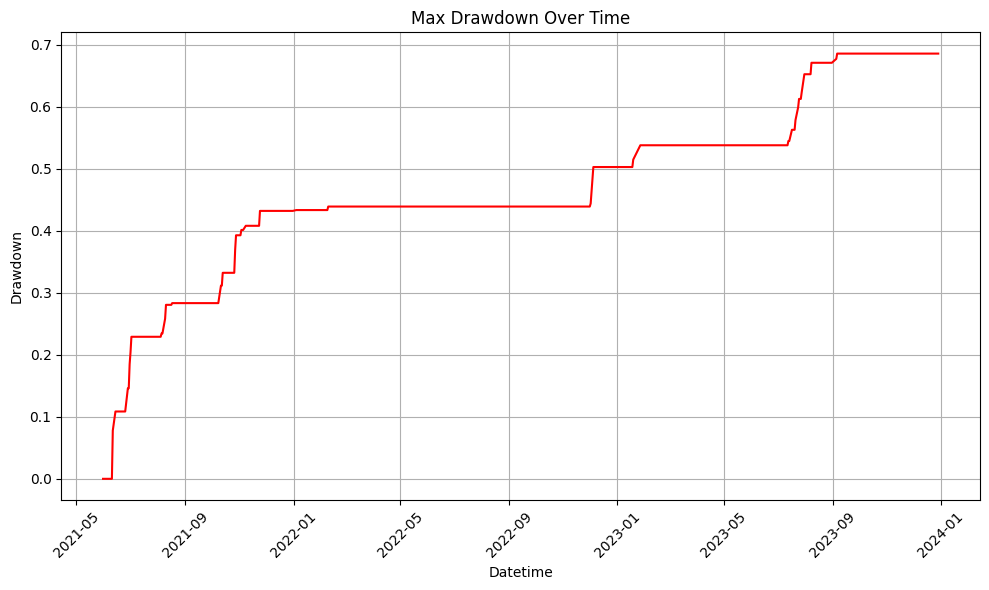

In [26]:
run_strategy_and_plot(
    Strategy_2, "ST2_best_params_1min.json", IS_matched_1min, "ST2_1min"
)

### Out-Sample

In [27]:
OS_matched_1D = pd.read_csv("Data\\OS_matched_1D.csv")
OS_matched_1D["datetime"] = pd.to_datetime(OS_matched_1D["datetime"])
OS_matched_5min = pd.read_csv("Data\\OS_matched_5min.csv")
OS_matched_5min["datetime"] = pd.to_datetime(OS_matched_5min["datetime"])
OS_matched_1min = pd.read_csv("Data\\OS_matched_1min.csv")
OS_matched_1min["datetime"] = pd.to_datetime(OS_matched_1min["datetime"])

#### 1 Day

Best Sharpe Ratio: -0.4768106061810873 - Best MDD: 0.2780319999999999
Profit: 0.7814304999999998
Best parameters: {'cut_loss_thres': 0.009199008454189143, 'lookback_period': 14, 'upbound': 0.009367476782809248, 'downbound': -0.0914652535006232, 'sma_window': 4}


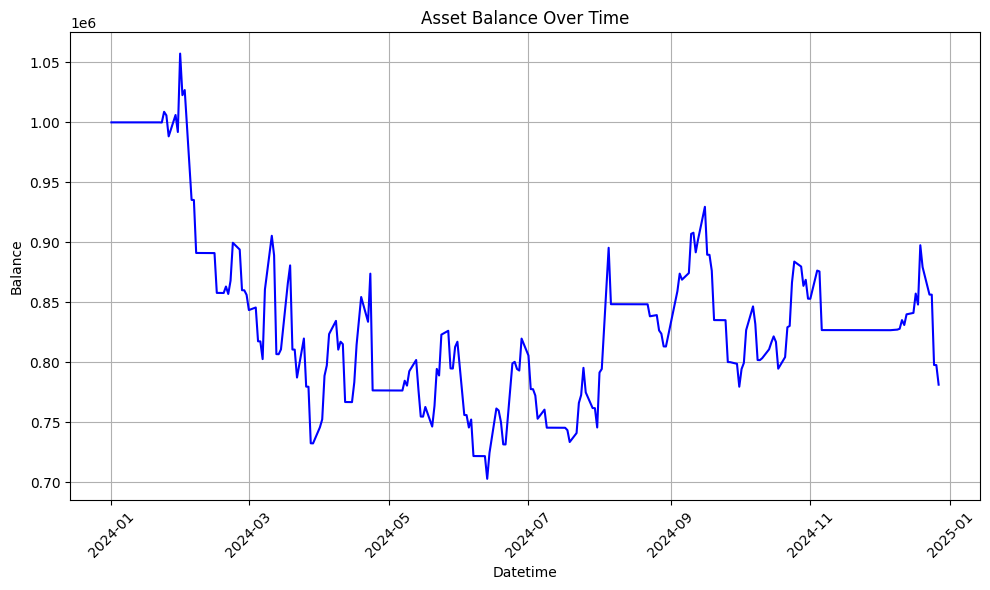

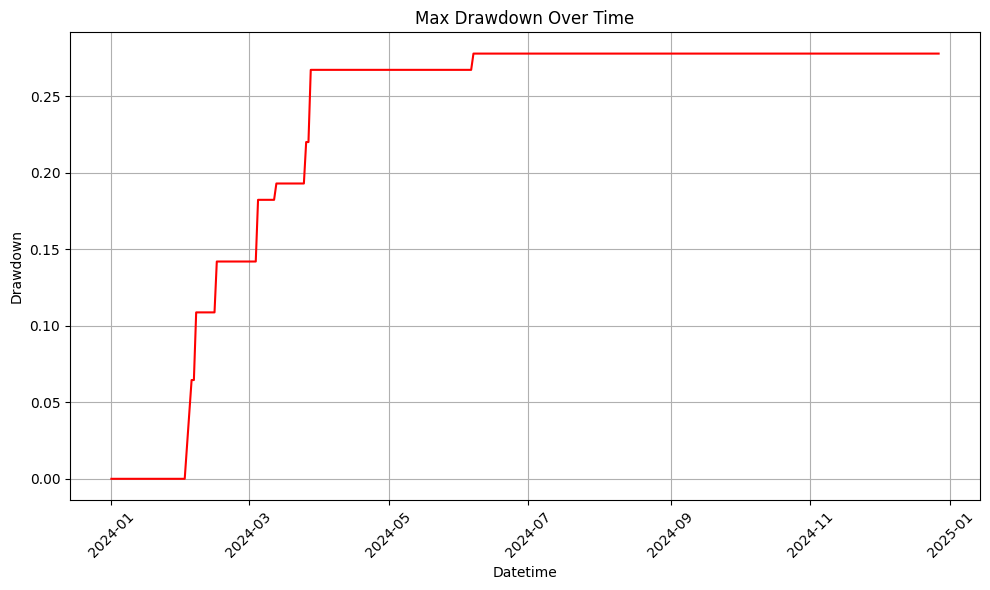

In [28]:
run_strategy_and_plot(
    Strategy_2, "ST2_best_params_1D.json", OS_matched_1D, "ST2_1D"
)

#### 5 Minutes

Best Sharpe Ratio: 0 - Best MDD: 0
Profit: 1.0
Best parameters: {'cut_loss_thres': 0.034813502795929194, 'lookback_period': 163, 'upbound': 0.10401360423556216, 'downbound': -0.09065794413134408, 'sma_window': 32}


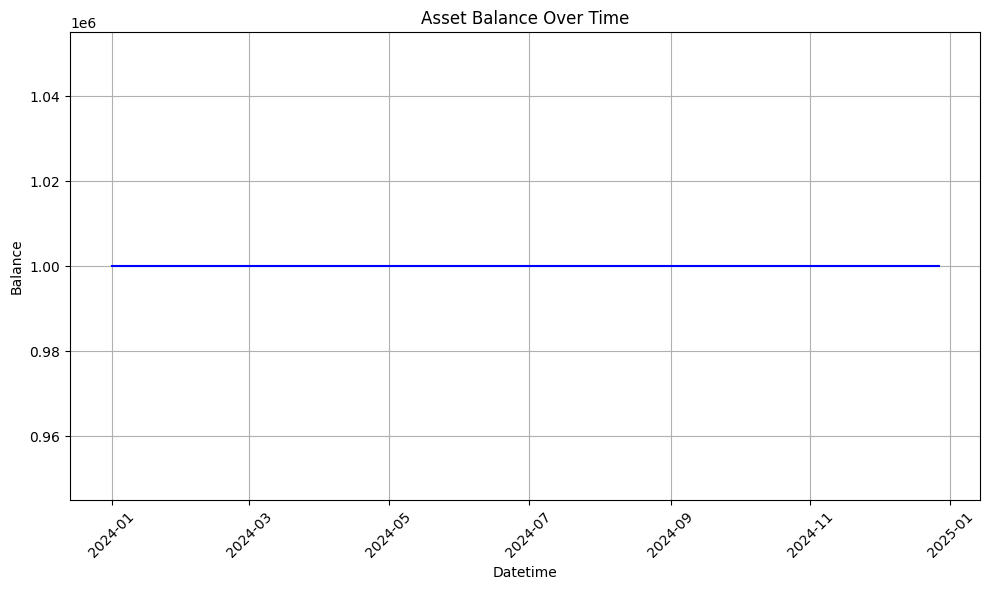

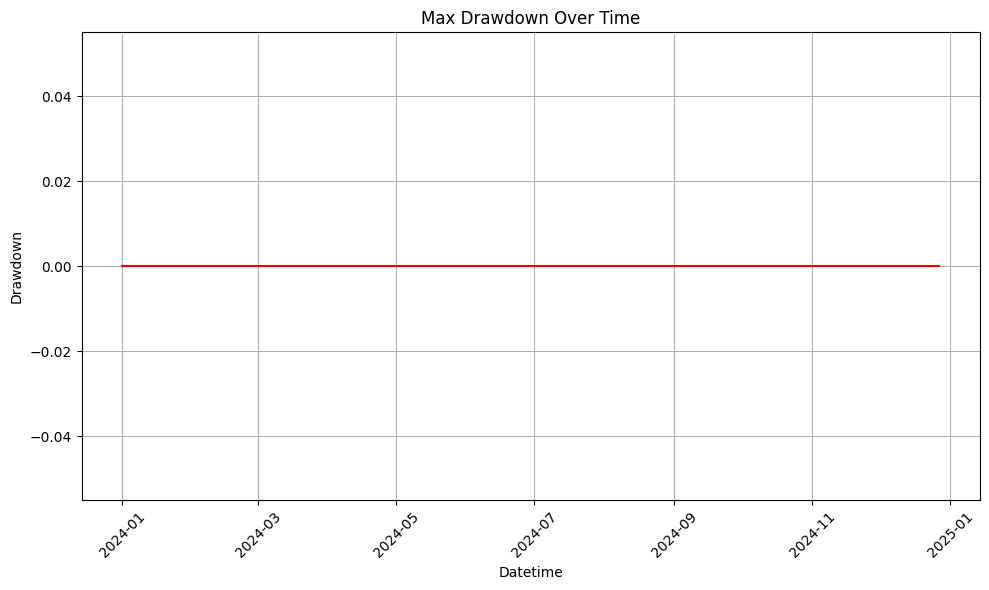

In [29]:
run_strategy_and_plot(
    Strategy_2, "ST2_best_params_5min.json", OS_matched_5min, "ST2_5min"
)

#### 1 Minute

Best Sharpe Ratio: -1.4256302286895879 - Best MDD: 0.5910090000000016
Profit: 0.43096399999999796
Best parameters: {'cut_loss_thres': 0.012670135982914067, 'lookback_period': 289, 'upbound': 0.009367476782809248, 'downbound': -0.06322841969405665, 'sma_window': 97}


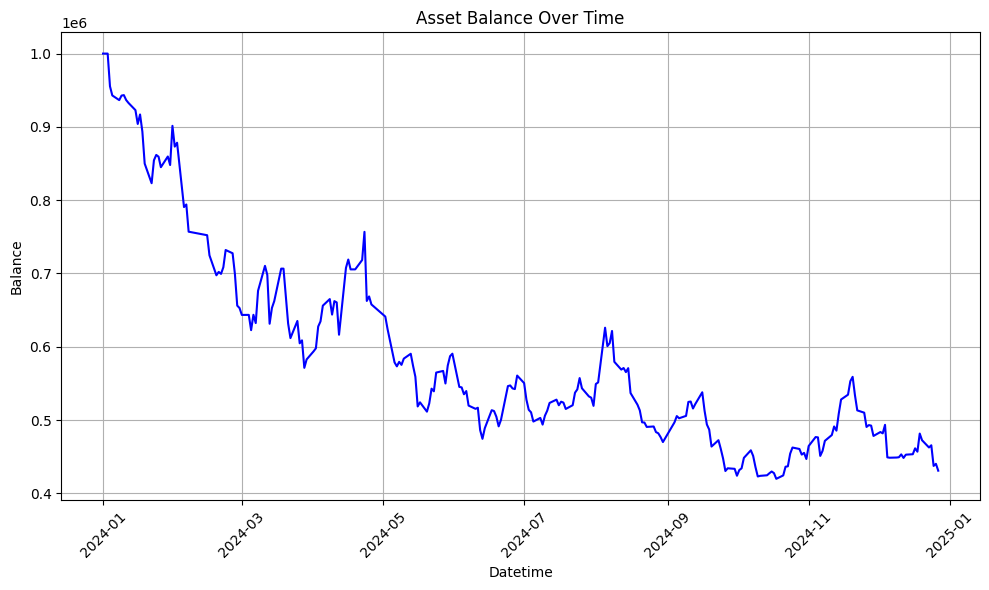

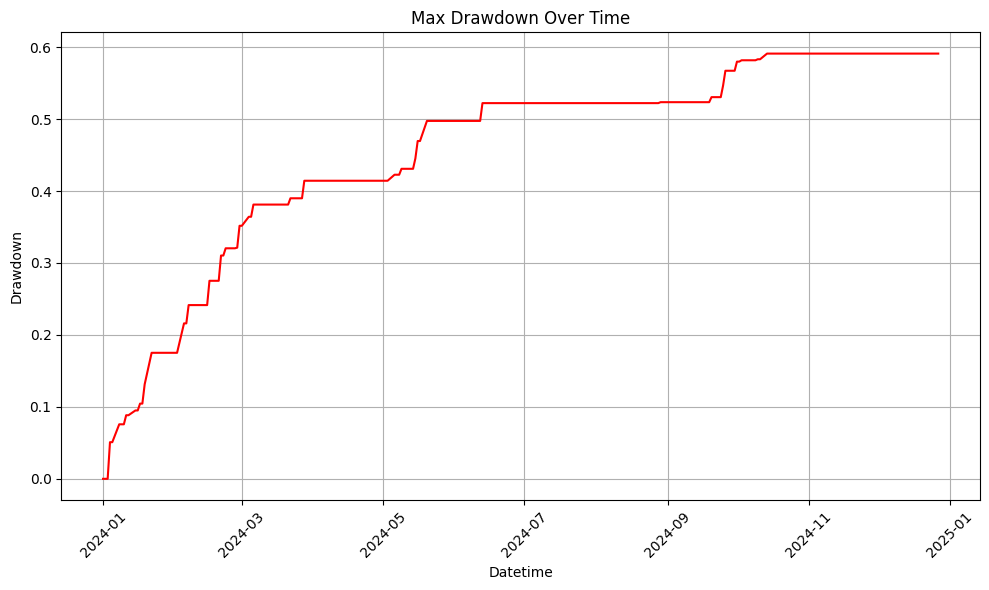

In [30]:
run_strategy_and_plot(
    Strategy_2, "ST2_best_params_1min.json", OS_matched_1min, "ST2_1min"
)